In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point

In [2]:
file_path = 'D:/data/'

# Step 1

## 1. facility data

In [3]:
# Import facilities' locations and remove all spaces and question marks from the '병원명' column.
facility = gpd.read_file(file_path + 'facilities.shp')
facility['병원명'] = facility['병원명'].str.replace(' ', '', regex=True)
facility['병원명'] = facility['병원명'].str.replace('?', '', regex=True)

# Rename the column '격리실' to 'capacity.'
facility = facility.rename(columns={'격리실': 'capacity'})


# Import facilities' buffer polygons (Service Areas analyzed in ArcMap).
fac_buffer = gpd.read_file(file_path + 'fac_buffer.shp')

# Extract and keep only Korean characters in the 'Name' column in fac_buffer.
fac_buffer['name'] = fac_buffer['Name'].str.extract('([가-힣 ]+)')

# Remove all spaces in the 'Name' column.
fac_buffer['name'] = fac_buffer['name'].str.replace(' ', '')


# Perform a spatial join between 'fac_buffer' and 'facility' based on the 'name' column.
fac_buffer = fac_buffer[['name', 'geometry']].merge(facility[['병원명', 'capacity']], left_on='name', right_on='병원명', how='left')
fac_buffer = fac_buffer[['name', 'capacity', 'geometry']]


# Create a copy of 'fac_buffer' as 'fac_buffer2'.
fac_buffer2 = fac_buffer.copy()

## 2. population data

In [4]:
# Import population density center points
point_pop = gpd.read_file(file_path + 'point_pop.shp')
point_pop['den'] = point_pop['SUM_1인']

# Import COVID-19 confirmed cases density center points
point_covid = gpd.read_file(file_path + 'point_covid.shp')
point_covid['den'] = point_covid['dencity']


# Import population buffer
pop_buffer = gpd.read_file(file_path + 'pop_buffer.shp')

## 3. spatial join

In [5]:
# Perform a spatial join between facility buffers and population density center points,
# as well as COVID-19 patient density center points.
fac_buf_dfs = [fac_buffer, fac_buffer2]
pop_dfs = [point_pop, point_covid]

for df, pop_df in zip(fac_buf_dfs, pop_dfs):
    result = gpd.sjoin(df, pop_df, how="inner", predicate="intersects")
    
    # Calculate the sum of population density ('den') for each facility buffer area.
    sum_pop_rate = result.groupby('name')['den'].sum().reset_index()
    sum_pop_rate.rename(columns={'den': 'den_sum'}, inplace=True)
    
    # Add a 'den_sum' column to the facility buffer data based on the calculated population density sums.
    df['den_sum'] = df['name'].map(sum_pop_rate.set_index('name')['den_sum'])

In [6]:
fac_buffer

,name,capacity,geometry,den_sum
0,의료법인박애의료재단박애병원,140.0,"POLYGON ((127.09856 37.03760, 127.09919 37.036...",7690795.0
1,의료법인백송의료재단굿모닝병원,5.0,"POLYGON ((127.12650 37.03198, 127.12655 37.031...",11179949.0
2,경기도의료원안성병원,5.0,"POLYGON ((127.25738 37.06077, 127.25747 37.059...",4176291.0
3,오산한국병원,5.0,"POLYGON ((127.08927 37.19112, 127.08927 37.188...",18068386.0
4,한림대학교동탄성심병원,14.0,"POLYGON ((127.08096 37.25723, 127.08087 37.256...",41481608.0
...,...,...,...,...
97,현대병원,38.0,"POLYGON ((127.19662 37.75513, 127.19662 37.755...",6852117.0
98,가톨릭대학교의정부성모병원,10.0,"POLYGON ((127.07565 37.80354, 127.07611 37.803...",32030680.0
99,의료법인일심의료재단우리병원,4.0,"POLYGON ((127.18089 37.86997, 127.17901 37.869...",172339.0
100,경기도의료원포천병원,1.0,"POLYGON ((127.18965 37.94835, 127.18925 37.946...",236367.0


In [7]:
fac_buffer2

,name,capacity,geometry,den_sum
0,의료법인박애의료재단박애병원,140.0,"POLYGON ((127.09856 37.03760, 127.09919 37.036...",4.586992
1,의료법인백송의료재단굿모닝병원,5.0,"POLYGON ((127.12650 37.03198, 127.12655 37.031...",3.248991
2,경기도의료원안성병원,5.0,"POLYGON ((127.25738 37.06077, 127.25747 37.059...",0.000000
3,오산한국병원,5.0,"POLYGON ((127.08927 37.19112, 127.08927 37.188...",1.452869
4,한림대학교동탄성심병원,14.0,"POLYGON ((127.08096 37.25723, 127.08087 37.256...",50.064918
...,...,...,...,...
97,현대병원,38.0,"POLYGON ((127.19662 37.75513, 127.19662 37.755...",0.000000
98,가톨릭대학교의정부성모병원,10.0,"POLYGON ((127.07565 37.80354, 127.07611 37.803...",23.552996
99,의료법인일심의료재단우리병원,4.0,"POLYGON ((127.18089 37.86997, 127.17901 37.869...",0.000000
100,경기도의료원포천병원,1.0,"POLYGON ((127.18965 37.94835, 127.18925 37.946...",0.000000


# Step 2

## 1. population data

In [8]:
# Import population buffer polygons (Service Areas analyzed in ArcMap).
pop_buffer = gpd.read_file(file_path + 'pop_buffer.shp')

# Extract and keep only the part before the colon in the 'Name' column and remove leading/trailing spaces.
pop_buffer['Name'] = pop_buffer['Name'].str.split(':').str[0].str.strip()

# Perform a spatial join between 'pop_buffer' and 'point_pop' based on the 'Name' and 'ADM_CD' columns.
pop_den_buffer = pop_buffer[['Name', 'geometry']].merge(point_pop[['ADM_CD', 'den']], left_on='Name', right_on='ADM_CD', how='left')
pop_den_buffer = pop_den_buffer[['Name', 'den', 'geometry']]
pop_den_buffer = pop_den_buffer.sort_values(by='Name', ascending=False)

# Perform a spatial join between 'pop_buffer' and 'point_covid' based on the 'Name' and 'ADM_CD' columns.
covid_den_buffer = pop_buffer[['Name', 'geometry']].merge(point_covid[['ADM_CD', 'den']], left_on='Name', right_on='ADM_CD', how='left')
covid_den_buffer = covid_den_buffer[['Name', 'den', 'geometry']]

In [9]:
pop_den_buffer

,Name,den,geometry
1103,3138041,1624.0,"POLYGON ((127.52185 37.47220, 127.52261 37.471..."
1106,3138040,250298.0,"POLYGON ((127.58823 37.54178, 127.58823 37.541..."
1104,3138039,2195.0,"POLYGON ((127.65349 37.48787, 127.65368 37.487..."
1109,3138038,465.0,"POLYGON ((127.73313 37.48487, 127.73304 37.484..."
1110,3138037,850.0,"POLYGON ((127.72707 37.56639, 127.72689 37.565..."
...,...,...,...
869,1101057,938649.0,"POLYGON ((126.93269 37.62051, 126.93300 37.620..."
875,1101056,327134.0,"POLYGON ((126.93287 37.62087, 126.93300 37.620..."
874,1101055,168747.0,"POLYGON ((126.93287 37.62087, 126.93300 37.620..."
873,1101054,34893.0,"POLYGON ((127.00999 37.61719, 127.01044 37.617..."


In [10]:
covid_den_buffer

,Name,den,geometry
0,3107037,0.0,"POLYGON ((126.93862 36.98379, 126.93781 36.981..."
1,3107013,0.0,"POLYGON ((126.87394 37.02156, 126.87295 37.018..."
2,3124039,0.0,"POLYGON ((126.84416 37.11072, 126.84394 37.109..."
3,3107012,0.0,"POLYGON ((126.93799 37.03499, 126.93804 37.034..."
4,3107034,0.0,"POLYGON ((126.98493 37.03153, 126.98529 37.030..."
...,...,...,...
1115,3137033,0.0,"POLYGON ((127.35786 37.82348, 127.35692 37.822..."
1116,3137036,0.0,"POLYGON ((127.35189 37.88996, 127.35189 37.889..."
1117,3137011,0.0,"POLYGON ((127.51587 37.86041, 127.51637 37.859..."
1118,3137035,0.0,"POLYGON ((127.45061 37.97561, 127.45160 37.973..."


## 2. spatial join

In [11]:
# Perform a spatial join between population buffer and facility buffer dataframes
dfs = [pop_den_buffer, covid_den_buffer]
fac_dfs = [fac_buffer, fac_buffer2]

for df, fac_df in zip(dfs, fac_dfs):
    result = gpd.sjoin(df, fac_df, how="inner", predicate="intersects")
    
    # Calculate the sum of 'den' values for each population buffer area.
    sum_ProToPop = result.groupby('Name')['den'].sum().reset_index()
    sum_ProToPop.rename(columns={'den': 'sfca'}, inplace=True)
    
    # Add an 'sfca' column to the population buffer dataframe based on the calculated 'den' sums.
    df['sfca'] = df['Name'].map(sum_ProToPop.set_index('Name')['sfca'])

In [12]:
pop_den_buffer

,Name,den,geometry,sfca
1103,3138041,1624.0,"POLYGON ((127.52185 37.47220, 127.52261 37.471...",NaN
1106,3138040,250298.0,"POLYGON ((127.58823 37.54178, 127.58823 37.541...",NaN
1104,3138039,2195.0,"POLYGON ((127.65349 37.48787, 127.65368 37.487...",NaN
1109,3138038,465.0,"POLYGON ((127.73313 37.48487, 127.73304 37.484...",NaN
1110,3138037,850.0,"POLYGON ((127.72707 37.56639, 127.72689 37.565...",NaN
...,...,...,...,...
869,1101057,938649.0,"POLYGON ((126.93269 37.62051, 126.93300 37.620...",15957033.0
875,1101056,327134.0,"POLYGON ((126.93287 37.62087, 126.93300 37.620...",4579876.0
874,1101055,168747.0,"POLYGON ((126.93287 37.62087, 126.93300 37.620...",2531205.0
873,1101054,34893.0,"POLYGON ((127.00999 37.61719, 127.01044 37.617...",662967.0


In [13]:
covid_den_buffer

,Name,den,geometry,sfca
0,3107037,0.0,"POLYGON ((126.93862 36.98379, 126.93781 36.981...",NaN
1,3107013,0.0,"POLYGON ((126.87394 37.02156, 126.87295 37.018...",NaN
2,3124039,0.0,"POLYGON ((126.84416 37.11072, 126.84394 37.109...",NaN
3,3107012,0.0,"POLYGON ((126.93799 37.03499, 126.93804 37.034...",NaN
4,3107034,0.0,"POLYGON ((126.98493 37.03153, 126.98529 37.030...",0.0
...,...,...,...,...
1115,3137033,0.0,"POLYGON ((127.35786 37.82348, 127.35692 37.822...",NaN
1116,3137036,0.0,"POLYGON ((127.35189 37.88996, 127.35189 37.889...",NaN
1117,3137011,0.0,"POLYGON ((127.51587 37.86041, 127.51637 37.859...",NaN
1118,3137035,0.0,"POLYGON ((127.45061 37.97561, 127.45160 37.973...",NaN


## 3. join to unit

In [14]:
# Load municipal boundaries data.
boundary = gpd.read_file(file_path + 'boundary.shp')

# Perform a spatial join between municipal boundaries and population density data ('pop_den_buffer').
pop_sfca = boundary[['ADM_CD', 'geometry']].merge(pop_den_buffer[['Name', 'sfca']], left_on='ADM_CD', right_on='Name', how='left')

# Perform a spatial join between municipal boundaries and COVID-19 patient density data ('covid_den_buffer').
covid_sfca = boundary[['ADM_CD', 'geometry']].merge(covid_den_buffer[['Name', 'sfca']], left_on='ADM_CD', right_on='Name', how='left')

# Export the resulting data to shapefiles.
# pop_sfca.to_file(file_path + 'pop_sfca.shp')
# covid_sfca.to_file(file_path + 'covid_sfca.shp')

In [15]:
pop_sfca

,ADM_CD,geometry,Name,sfca
0,1101053,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",1101053,9304509.0
1,1101054,"POLYGON ((126.97714 37.59768, 126.97730 37.597...",1101054,662967.0
2,1101055,"POLYGON ((126.96173 37.60714, 126.96182 37.607...",1101055,2531205.0
3,1101056,"POLYGON ((126.97509 37.63118, 126.97488 37.630...",1101056,4579876.0
4,1101057,"POLYGON ((126.95975 37.58001, 126.96006 37.579...",1101057,15957033.0
...,...,...,...,...
1121,3138037,"POLYGON ((127.75530 37.59080, 127.75578 37.590...",3138037,NaN
1122,3138038,"POLYGON ((127.70828 37.51741, 127.70838 37.516...",3138038,NaN
1123,3138039,"POLYGON ((127.63385 37.50712, 127.63387 37.506...",3138039,NaN
1124,3138040,"POLYGON ((127.60479 37.58071, 127.60561 37.580...",3138040,NaN


In [16]:
covid_sfca

,ADM_CD,geometry,Name,sfca
0,1101053,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",1101053,16.399963
1,1101054,"POLYGON ((126.97714 37.59768, 126.97730 37.597...",1101054,12.844319
2,1101055,"POLYGON ((126.96173 37.60714, 126.96182 37.607...",1101055,0.000000
3,1101056,"POLYGON ((126.97509 37.63118, 126.97488 37.630...",1101056,1.564712
4,1101057,"POLYGON ((126.95975 37.58001, 126.96006 37.579...",1101057,0.000000
...,...,...,...,...
1121,3138037,"POLYGON ((127.75530 37.59080, 127.75578 37.590...",3138037,NaN
1122,3138038,"POLYGON ((127.70828 37.51741, 127.70838 37.516...",3138038,NaN
1123,3138039,"POLYGON ((127.63385 37.50712, 127.63387 37.506...",3138039,NaN
1124,3138040,"POLYGON ((127.60479 37.58071, 127.60561 37.580...",3138040,NaN


# Result maps

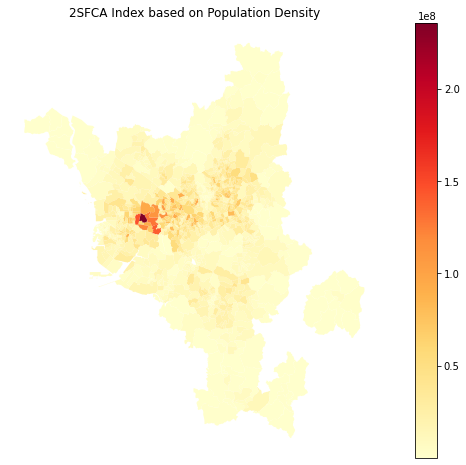

In [17]:
# Choropleth Map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pop_sfca.plot(column='sfca', cmap='YlOrRd', linewidth=0.8, ax=ax, legend=True)

# Add Legend
ax.set_title('2SFCA Index based on Population Density')
ax.set_axis_off()
plt.show()

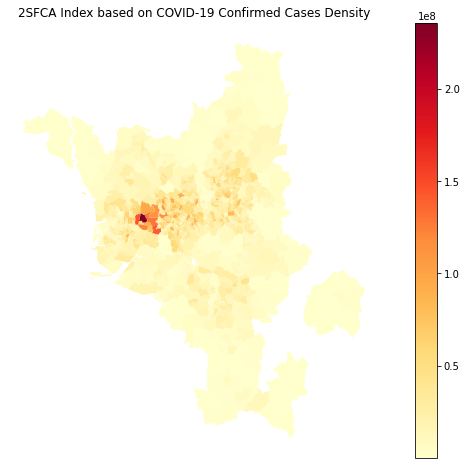

In [18]:
# Choropleth Map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pop_sfca.plot(column='sfca', cmap='YlOrRd', linewidth=0.8, ax=ax, legend=True)

# Add Legend
ax.set_title('2SFCA Index based on COVID-19 Confirmed Cases Density')
ax.set_axis_off()
plt.show()